# S15 T01 Aprendizaje no supervisado: Clustering

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tarfile
import urllib

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import Normalizer

from kneed import KneeLocator

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.metrics import calinski_harabasz_score

In [2]:
# Air Delay data has integer numbers
pd.options.display.float_format = '{:.2f}'.format

# Read the data into a dataframe
df_leido = pd.read_csv('DelayedFlights.csv', sep=',')

# Use a sample so that the memory does not overflow
# df_raw = df_leido.sample(frac=0.1, random_state=9)
# Instead of this sample I want a sample where all delays are being represented

# Sort by ArrDelay and then make a sistematic sample
df_leido = df_leido.sort_values(by=['ArrDelay'])


np.random.seed(10)
pop = len(df_leido)
# sample_size = 150000
sample_size = 30000  # I´m running with a small sample because Exercise 2 is too much for my computer

# calculate the step
step = int(pop / sample_size)
start = np.random.randint(step)
df_raw = df_leido.iloc[start::step].reset_index(drop=True).copy() # uso copy para que sean df diferentes y no se afecten el uno al otro


In [3]:
pd.options.display.max_columns = 25

In [4]:
print(df_raw.info())

# Look at the first rows
df_raw.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30262 entries, 0 to 30261
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         30262 non-null  int64  
 1   Year               30262 non-null  int64  
 2   Month              30262 non-null  int64  
 3   DayofMonth         30262 non-null  int64  
 4   DayOfWeek          30262 non-null  int64  
 5   DepTime            30262 non-null  float64
 6   CRSDepTime         30262 non-null  int64  
 7   ArrTime            30147 non-null  float64
 8   CRSArrTime         30262 non-null  int64  
 9   UniqueCarrier      30262 non-null  object 
 10  FlightNum          30262 non-null  int64  
 11  TailNum            30262 non-null  object 
 12  ActualElapsedTime  30131 non-null  float64
 13  CRSElapsedTime     30261 non-null  float64
 14  AirTime            30131 non-null  float64
 15  ArrDelay           30131 non-null  float64
 16  DepDelay           302

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,...,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1555765,2008,3,30,7,2127.00,2120,438.00,540,FL,693,N174AT,...,MCO,2148,8.00,10.00,0,N,0,nan,nan,nan,nan,nan
1,6943943,2008,12,2,2,2210.00,2204,427.00,515,AS,871,N584AS,...,ANC,2777,4.00,17.00,0,N,0,nan,nan,nan,nan,nan
2,316920,2008,1,27,7,1846.00,1840,2112.00,2156,DL,135,N647DL,...,ATL,760,7.00,42.00,0,N,0,nan,nan,nan,nan,nan
3,4219533,2008,7,9,3,1918.00,1910,2211.00,2253,DL,1581,N652DL,...,SLC,1989,5.00,17.00,0,N,0,nan,nan,nan,nan,nan
4,539927,2008,1,16,3,2217.00,2210,450.00,530,AS,871,N570AS,...,ANC,2777,4.00,16.00,0,N,0,nan,nan,nan,nan,nan
5,2029313,2008,4,2,3,1322.00,1315,2120.00,2159,UA,824,N547UA,...,BOS,2704,6.00,19.00,0,N,0,nan,nan,nan,nan,nan
6,893137,2008,2,17,7,1633.00,1625,1918.00,1956,DL,79,N923DL,...,MCO,944,8.00,20.00,0,N,0,nan,nan,nan,nan,nan
7,4306332,2008,8,24,7,1812.00,1800,2108.00,2145,WN,372,N619SW,...,PHL,813,6.00,6.00,0,N,0,nan,nan,nan,nan,nan
8,2699802,2008,5,25,7,1546.00,1540,1819.00,1855,DL,79,N973DL,...,MCO,944,3.00,28.00,0,N,0,nan,nan,nan,nan,nan
9,6133308,2008,11,29,6,1506.00,1458,1712.00,1747,UA,149,N530UA,...,SFO,1846,5.00,12.00,0,N,0,nan,nan,nan,nan,nan


### This dataset is composed by the following variables:
1. Year 2008
2. Month 1-12
3. DayofMonth 1-31
4. DayOfWeek 1 (Monday) - 7 (Sunday)
5. DepTime actual departure time (local, hhmm)
6. CRSDepTime scheduled departure time (local, hhmm)
7. ArrTime actual arrival time (local, hhmm)
8. CRSArrTime scheduled arrival time (local, hhmm)
9. UniqueCarrier unique carrier code
10. FlightNum flight number
11. TailNum plane tail number: aircraft registration, unique aircraft identifier
12. ActualElapsedTime in minutes
13. CRSElapsedTime in minutes
14. AirTime in minutes
15. ArrDelay arrival delay, in minutes: A flight is counted as "on time" if it operated less than 15 minutes later the scheduled time shown in the carriers' Computerized Reservations Systems (CRS).
16. DepDelay departure delay, in minutes
17. Origin origin IATA airport code
18. Dest destination IATA airport code
19. Distance in miles
20. TaxiIn taxi in time, in minutes
21. TaxiOut taxi out time in minutes
22. Cancelled *was the flight cancelled
23. CancellationCode reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24. Diverted 1 = yes, 0 = no
25. CarrierDelay in minutes: Carrier delay is within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.
26. WeatherDelay in minutes: Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.
27. NASDelay in minutes: Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc.
28. SecurityDelay in minutes: Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.
29. LateAircraftDelay in minutes: Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation.

In [5]:
# drop variables with no information
df_raw.drop("Unnamed: 0",1, inplace=True) # Vacío
df_raw.drop("Year",1, inplace=True) # Son todos datos del mismo año

# drop other variables that don´t seem usefull, as analysed in Sprint 12
df_raw.drop("TailNum",1, inplace=True)
df_raw.drop(["FlightNum", "DayOfWeek", "CRSElapsedTime", 'CRSDepTime', 'CRSArrTime', 'TaxiIn', 'TaxiOut'],1, inplace=True)
df_raw.drop([ "ActualElapsedTime", 'AirTime'],1, inplace=True) # están altamente relacionadas con Distance
df_raw.drop("Dest",1, inplace=True)


Fill null values with 0 in all XXXDelay as analized in Srint 12 Task 01

In [6]:
df_raw['CarrierDelay'].fillna(0, inplace=True)
df_raw['WeatherDelay'].fillna(0, inplace=True)
df_raw['NASDelay'].fillna(0, inplace=True)
df_raw['SecurityDelay'].fillna(0, inplace=True)
df_raw['LateAircraftDelay'].fillna(0, inplace=True)

In [7]:
# I`m not interested in the different kinds of delays
df_raw['XXXDelay'] = df_raw.CarrierDelay + df_raw.WeatherDelay + df_raw.NASDelay + df_raw.SecurityDelay + df_raw.LateAircraftDelay
df_raw.drop(['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],1, inplace=True)

In [8]:
# identificar variables cíclicas
ciclicas = ['Month', 'DayofMonth']
# seleccionar las variables categóricas
categoricas = ['UniqueCarrier', 'Origin',   # 'Dest', 
                'CancellationCode']
# identificar variables binarias
binarias = ['Cancelled', 'Diverted']

# change object types to category types
for cat in categoricas:
    df_raw[cat] = df_raw[cat].astype('category')

In [9]:
df_raw.isnull().sum()

Month                 0
DayofMonth            0
DepTime               0
ArrTime             115
UniqueCarrier         0
ArrDelay            131
DepDelay              0
Origin                0
Distance              0
Cancelled             0
CancellationCode      0
Diverted              0
XXXDelay              0
dtype: int64

All the other null values I'll also fill them with 0, even the time variables, like ArrTime. All of these flights are Cancelled or Diverted, that´s why I don´t use the average for them. 

In [10]:
df_raw['ArrTime'].fillna(0, inplace=True)
df_raw['ArrDelay'].fillna(0, inplace=True)

In [11]:
# Check that there´s no null values left
df_raw.isnull().values.sum()

0

Let´s see what the categorical features look like

In [12]:
def analizar_cat(df,label):
    print('Variable:', label)
    print('Tiene ', df[label].value_counts().count(), 'valores diferentes')
    print('Con forma: ', df[label].value_counts().head(10))
    print()
 
for l in categoricas:
    analizar_cat(df_raw,l)


Variable: UniqueCarrier
Tiene  20 valores diferentes
Con forma:  WN    5773
AA    3022
MQ    2276
UA    2199
OO    2094
DL    1813
CO    1613
XE    1610
US    1544
EV    1274
Name: UniqueCarrier, dtype: int64

Variable: Origin
Tiene  282 valores diferentes
Con forma:  ATL    2069
ORD    2018
DFW    1454
DEN    1098
IAH     909
LAX     885
LAS     871
EWR     864
PHX     835
DTW     649
Name: Origin, dtype: int64

Variable: CancellationCode
Tiene  4 valores diferentes
Con forma:  N    30248
A        7
B        6
C        1
Name: CancellationCode, dtype: int64



### Encode categorical variables

I can´t find a way to group these categories. CancellationCode only has 4 values, so I´ll normaize it to dummies. The rest I´ll just encode.


In [13]:
df = df_raw.copy()  # in order not to loose the original data

In [14]:
# Encode Cancellation code as dummies
# change the name of the codes
replace_map_codes = {'N': 'CCode N', 'A': 'CCode A', 'B': 'CCode B', 'C': 'CCode C'} 

df['CancellationCode'].replace(replace_map_codes, inplace=True) 

# normalize in dummies
cc = pd.get_dummies(df['CancellationCode'])
df = pd.concat([df, cc], axis=1)
df = df.drop(['CancellationCode'], axis =1)



In [15]:
# apply LabelEncoder to categorical features
categoricas.remove("CancellationCode") # it was already dealt with
for cat in categoricas:
    lb_make = LabelEncoder()
    df[cat] = lb_make.fit_transform(df[cat])


In [16]:
# a manual way of encoding (you can assign your own values)
# labels = df['UniqueCarrier'].astype('category').cat.categories.tolist()
# replace_map_comp = {'UniqueCarrier' : {k: v for k,v in zip(labels,list(range(0,len(labels))))}}

# df.replace(replace_map_comp, inplace=True)
# df['UniqueCarrier'].value_counts().head(10)

### Cyclic features

I need to deal with Month and Day as cyclic features

In [17]:
# define a function to codify cyclic variables
def encode_cy(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    data.drop(col, inplace =True, axis=1)
    return data

In [18]:
encode_cy(df, 'Month', 12)
encode_cy(df, 'DayofMonth', 31)

,DepTime,ArrTime,UniqueCarrier,ArrDelay,DepDelay,Origin,Distance,Cancelled,Diverted,XXXDelay,CCode A,CCode B,CCode C,CCode N,Month_sin,Month_cos,DayofMonth_sin,DayofMonth_cos
0,2127.00,438.00,9,-62.00,7.00,231,2148,0,0,0.00,0,0,0,1,1.00,0.00,-0.20,0.98
1,2210.00,427.00,3,-48.00,6.00,121,2777,0,0,0.00,0,0,0,1,-0.00,1.00,0.39,0.92
2,1846.00,2112.00,6,-44.00,6.00,139,760,0,0,0.00,0,0,0,1,0.50,0.87,-0.72,0.69
3,1918.00,2211.00,6,-42.00,8.00,139,1989,0,0,0.00,0,0,0,1,-0.50,-0.87,0.97,-0.25
4,2217.00,450.00,3,-40.00,7.00,121,2777,0,0,0.00,0,0,0,1,0.50,0.87,-0.10,-0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30257,715.00,1313.00,1,0.00,10.00,223,1158,0,1,0.00,0,0,0,1,-0.00,1.00,-0.72,0.69
30258,806.00,1345.00,3,0.00,6.00,207,1009,0,1,0.00,0,0,0,1,-0.00,1.00,-0.97,-0.25
30259,1205.00,1747.00,4,0.00,25.00,139,2465,0,1,0.00,0,0,0,1,-0.00,1.00,-0.49,-0.87
30260,2318.00,0.00,4,0.00,58.00,231,2588,1,0,0.00,1,0,0,0,-0.00,1.00,-0.94,0.35


## Exercici 1
Classifica els diferents vols utilitzant l'algorisme de K-means

First scale the data

In [19]:
# Separate categorical variables not to scale
# not_scale = ['UniqueCarrier','Origin','Dest','Cancelled','Diverted','CCode A','CCode B','CCode C','CCode N']
not_scale = ['UniqueCarrier','Origin','Cancelled','Diverted','CCode A','CCode B','CCode C','CCode N']

df_sc = pd.DataFrame()
df_notc = pd.DataFrame()
for var in df.columns:
    if var in not_scale:
        df_notc[var] = df[var]
    else:
        df_sc[var] = df[var]
        
scaler = MinMaxScaler()
X_sc = scaler.fit_transform(df_sc)
X_notc = df_notc.values

X_notc.shape

(30262, 8)

In [20]:
# Join the not scaled (categorical variables)
X = np.append(X_sc, X_notc, axis=1)
    
X.shape


(30262, 18)

Apply PCA to reduce features and then KMeans

In [21]:
# apply PCA
pca = PCA(n_components=.95, random_state=42)  # keep 95% variability
X_PCA = pca.fit_transform(X)

# Choose a number of clusters (will need to run with different values) 
nro_k=5  #(I choose this number after finishing Excercise 3)

# Here´s the model
kmeans = KMeans(
               n_clusters=nro_k,
               init="k-means++",    # el default es random, este parece facilitar la convergencia
               n_init=50,    # es la cantidad de veces que se inicializa, el default es 10
               max_iter=500,   # máximo de iteraciones
               random_state=42,
           )
kmeans.fit(X_PCA)


KMeans(max_iter=500, n_clusters=5, n_init=50, random_state=42)

In [22]:
predicted_labels = kmeans.labels_

In [23]:
# add the clusters to the original dataframe
df_raw['cluster'] = predicted_labels
df_raw

,Month,DayofMonth,DepTime,ArrTime,UniqueCarrier,ArrDelay,DepDelay,Origin,Distance,Cancelled,CancellationCode,Diverted,XXXDelay,cluster
0,3,30,2127.00,438.00,FL,-62.00,7.00,SAN,2148,0,N,0,0.00,2
1,12,2,2210.00,427.00,AS,-48.00,6.00,HNL,2777,0,N,0,0.00,0
2,1,27,1846.00,2112.00,DL,-44.00,6.00,JFK,760,0,N,0,0.00,0
3,7,9,1918.00,2211.00,DL,-42.00,8.00,JFK,1989,0,N,0,0.00,0
4,1,16,2217.00,450.00,AS,-40.00,7.00,HNL,2777,0,N,0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30257,12,27,715.00,1313.00,AA,0.00,10.00,RIC,1158,0,N,1,0.00,2
30258,12,22,806.00,1345.00,AS,0.00,6.00,PHX,1009,0,N,1,0.00,4
30259,12,18,1205.00,1747.00,B6,0.00,25.00,JFK,2465,0,N,1,0.00,0
30260,12,25,2318.00,0.00,B6,0.00,58.00,SAN,2588,1,A,0,0.00,2


In [24]:
# How many elements do the clusters have?
clusters = np.unique(predicted_labels, return_counts=True)
print(clusters)

(array([0, 1, 2, 3, 4]), array([7325, 4621, 4970, 6995, 6351], dtype=int64))


In [25]:
# Analize clusters, see the most frequent value for each feature
cluster_data = pd.DataFrame()
for cl in clusters[0]:
    cluster_data.at[cl,'Cluster'] = cl
    cluster_data.at[cl,'Elements'] = clusters[1][cl]
    for col in df_raw.columns:
        if col in categoricas or df_raw[col].dtype== 'category':
            # for categorical variables choose the category with most appearances
            cluster_data.at[cl,col] = df_raw[df_raw.cluster == cl][col].value_counts(sort=True).index[0]
        else:
            # for numeric data choose the median
            cluster_data.at[cl,col] = np.median(df_raw[df_raw.cluster == cl][col])

pd.options.display.max_columns = 25
cluster_data

,Cluster,Elements,Month,DayofMonth,DepTime,ArrTime,UniqueCarrier,ArrDelay,DepDelay,Origin,Distance,Cancelled,CancellationCode,Diverted,XXXDelay,cluster
0,0.00,7325.00,6.00,16.00,1555.00,1710.00,WN,22.00,24.00,IAH,689.00,0.00,N,0.00,22.00,0.00
1,1.00,4621.00,6.00,16.00,1610.00,1719.00,WN,25.00,24.00,ATL,542.00,0.00,N,0.00,25.00,1.00
2,2.00,4970.00,6.00,16.00,1507.00,1710.00,WN,23.00,24.00,SFO,599.00,0.00,N,0.00,23.00,2.00
3,3.00,6995.00,6.00,16.00,1551.00,1715.00,AA,25.00,24.00,DFW,609.00,0.00,N,0.00,25.00,3.00
4,4.00,6351.00,6.00,16.00,1549.00,1719.00,WN,26.00,26.00,ORD,622.00,0.00,N,0.00,26.00,4.00


The difference between the cluster is not clear, I don´t see the criteria for the grouping. Could be something that has to do with the origin and the distance...


## Exercici 2

Classifica els diferents vols utilitzant l'algorisme de clustering jeràrquic.

In [26]:
# Separate categorical variables not to normalize
not_norm = not_scale

df_norm = pd.DataFrame()
df_notn = pd.DataFrame()
for var in df.columns:
    if var in not_norm:
        df_notn[var] = df[var]
    else:
        df_norm[var] = df[var]
        
norm = Normalizer()
X_norm = norm.fit_transform(df_norm)
X_notn = df_notn.values


In [27]:
# Join the not normalized (categorical variables)
Xn = np.append(X_norm, X_notn, axis=1)
    
Xn.shape


(30262, 18)

In [28]:
# apply PCA
pca = PCA(n_components=.95, random_state=42)  # keep 95% variability
X_PCAn = pca.fit_transform(X)


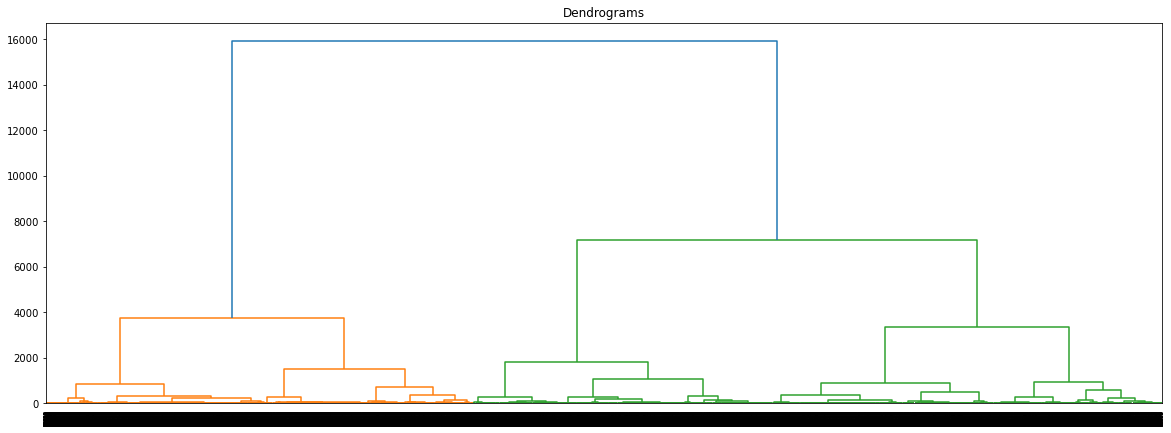

In [29]:
plt.figure(figsize=(20, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_PCAn, method='ward'))

In the dentogram, we see that the tallest distance is when we have 2 clusters. I´ll run the model with k=2.

After running with different values of k I see that the silhoutte value is the better when k=5

In [30]:
model = AgglomerativeClustering(n_clusters = 5, affinity='euclidean', linkage='ward')
model.fit(X_PCAn)
labels_n = model.labels_

In [47]:
# How many clusters did we get?
clusters = np.unique(labels_n, return_counts=True)
print(clusters)

(array([0, 1, 2, 3, 4], dtype=int64), array([8116, 5607, 4471, 5974, 6094], dtype=int64))


In [54]:
df_raw['cluster'] = labels_n

In [55]:
# Analize clusters, see the most frequent value for each feature
cluster_data = pd.DataFrame()
for cl in clusters[0]:
    cluster_data.at[cl,'Cluster'] = cl
    cluster_data.at[cl,'Elements'] = clusters[1][cl]
    for col in df_raw.columns:
        if col in categoricas or df_raw[col].dtype== 'category':
            # for categorical variables choose the category with most appearances
            cluster_data.at[cl,col] = df_raw[df_raw.cluster == cl][col].value_counts(sort=True).index[0]
        else:
            # for numeric data choose the median
            cluster_data.at[cl,col] = np.median(df_raw[df_raw.cluster == cl][col])

pd.options.display.max_columns = 25
cluster_data

,Cluster,Elements,Month,DayofMonth,DepTime,ArrTime,UniqueCarrier,ArrDelay,DepDelay,Origin,Distance,Cancelled,CancellationCode,Diverted,XXXDelay,cluster
0,0.00,8116.00,6.00,16.00,1555.00,1710.00,WN,23.00,24.00,IAH,690.50,0.00,N,0.00,23.00,0.00
1,1.00,5607.00,6.00,16.00,1609.00,1715.00,WN,25.00,24.00,ATL,529.00,0.00,N,0.00,25.00,1.00
2,2.00,4471.00,6.00,16.00,1502.00,1709.00,WN,22.00,23.00,SFO,621.00,0.00,N,0.00,22.00,2.00
3,3.00,5974.00,6.00,16.00,1550.00,1719.00,AA,25.00,24.00,DFW,632.00,0.00,N,0.00,25.00,3.00
4,4.00,6094.00,6.00,16.00,1548.00,1720.00,WN,25.00,26.00,ORD,601.00,0.00,N,0.00,25.00,4.00


## Exercici 3

Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.

In [32]:
# Use SSE (sum of the square error) and silhouette_score to evaluate a good k (number of clusters)
kmeans_kwargs = {
               'init': "k-means++",    # el default es random, este parece facilitar la convergencia
               'n_init': 50,    # es la cantidad de veces que se inicializa, el default es 10
               'max_iter': 500,   # máximo de iteraciones
               'random_state': 42
}

# define the max k-number to evaluate the model
max_range = 20

# A list holds the SSE values for each k
# Empty lists to hold evaluation metrics
silhouette_scores = []
sse_scores = []
for nro_k in range(2, max_range):
    kmeans = KMeans(n_clusters=nro_k, **kmeans_kwargs)
    kmeans.fit(X_PCA)
    sse_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_PCA, kmeans.labels_))


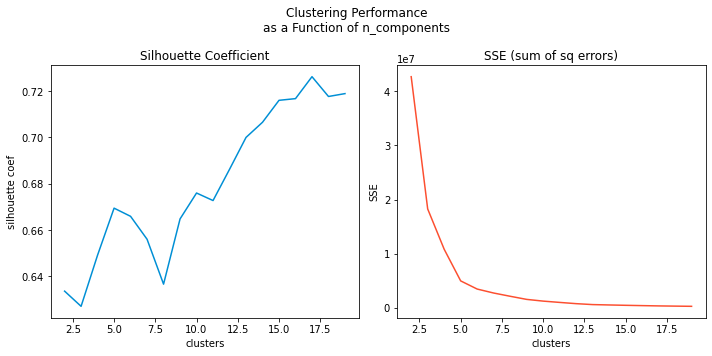

In [33]:
# Plot the values of the metrics along with the number of clusters
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(
    range(2, max_range),
    silhouette_scores,
    c="#008fd5",
    label="Silhouette Coefficient",
)
ax2.plot(range(2, max_range), sse_scores, c="#fc4f30", label="SSE")

ax1.set_title("Silhouette Coefficient")
ax2.set_title("SSE (sum of sq errors)")
#ax1.legend()
ax1.set_xlabel('clusters')
ax1.set_ylabel('silhouette coef')
#ax2.legend()
ax2.set_xlabel('clusters')
ax2.set_ylabel('SSE')
fig.suptitle("Clustering Performance\nas a Function of n_components")
fig.tight_layout()


I use SSE to determine the cluster number. The best k is the one where the elbow of the line is located. In this case it is 5.

Five also seems a good number for silhouette score, so I chose k=5 for Exercise 1. 

In Exercise 2 the dendogram shows that 2 is a good number of clusters. I run the model both, with 2 and 5 and 5 has a better silhouette score. 


In [34]:
# When the elbow is difficult to identify:
kl = KneeLocator(range(2, max_range), sse_scores, curve="convex", direction="decreasing")
kl.elbow

5

In [35]:
print('Silhouette scores:', silhouette_scores)
print('Silhouette score kmeans para k= 5', silhouette_scores[3])
print('Silhouette score para cluster jerárquico con k=5: ', silhouette_score(X_PCAn, labels_n))

Silhouette scores: [0.6336786290203182, 0.6271278806459027, 0.6492357063687817, 0.6694991615594641, 0.6659725935463373, 0.6560817414602429, 0.6366962747960878, 0.6648447805419578, 0.6760351549286143, 0.6727825508709028, 0.6862605927256977, 0.7000294228162206, 0.7065746147499091, 0.7160460927110218, 0.716774151407644, 0.7262478447958507, 0.7176993623051845, 0.7189395282625803]
Silhouette score kmeans para k= 5 0.6694991615594641
Silhouette score para cluster jerárquico con k=5:  0.6448511706177201


Another measure can be Calinski-Harabasz score: the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared. The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster

In [46]:
print('Calinski-Harabasz score for k-means clustering:', round(calinski_harabasz_score(X_PCA, kmeans.labels_),2))
print('Calinski-Harabasz score for hierarchical clustering:', round(calinski_harabasz_score(X_PCAn, labels_n),2))

Calinski-Harabasz score for k-means clustering: 957460.1
Calinski-Harabasz score for hierarchical clustering: 221923.63


In [64]:
# Do the predicted clusters coincide?
cant = sum(labels_n == kmeans.labels_)
tot = len(labels_n)
pct = round(100 * cant / tot, 2)
print(f'Coinciden {cant} de {tot}')
print(f'el {pct} %')

Coinciden 7008 de 30262
el 23.16 %
